In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd as xd
import openpyxl
import datetime as dt
import seaborn as sns
import requests
import math
import warnings
from scipy import interpolate
import tabula
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
import xlsxwriter
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import r2_score



warnings.filterwarnings('ignore')

# Data

In [6]:
# Prices
prices = pd.read_csv('data/merged house prices.csv') #thanks to Peter Abelson, ABS, Domain
prices = prices.set_index(prices['Year'])
prices = prices.drop('Year', axis = 1)

In [423]:
# Mortgage rates - import from previous version
excel = 'interestRates.xlsx'
dfs = pd.read_excel(excel, sheet_name=None)
interestRates = dfs['monthly']
yearlyRatesEMR = dfs['yearly avg emr']

In [340]:
# forward rates
forwardRates = pd.read_csv('forwardRates.csv')
forwardRates = forwardRates.drop('Index', axis = 1)

In [8]:
# Incomes
MIM = pd.read_csv('data/MedianIncomes.csv')
MIM = MIM.set_index(MIM['Date']).astype(float)
MIM = MIM.drop('Date', axis = 1)
MIF = pd.read_csv('data/MedianIncomesFemales.csv')
MIF = MIF.set_index(MIF['Date']).astype(float)
MIF = MIF.drop('Date', axis = 1)

In [9]:
#dealing with missing values via interpolation
for col in MIM.columns:
    MIM[col] = MIM[col].interpolate()
    MIF[col] = MIF[col].interpolate()

In [13]:
MIH = MIM + MIF

In [14]:
MIH = MIH*4 # working in months

## Applying symmetry

In [17]:
prices = prices[5:]
yearlyRatesEMR = yearlyRatesEMR[6:]

## Assumptions

In [18]:
loans = prices*1
deposit = prices*0.2
# payments = MIH*0.27 because we are going to try and set everyone equal years and such that there is no infiniti

# Making Constant Inputs Econometrics Panels

In [20]:
#let's calc constant years if rates and incomes stayed same
constantyearsdeposit = prices*0 
constantyearsloan = prices*0 #create a database for years

Variable of interest is payments, initially it was set at 0.27 the MIH. There are no issues with deposits...

In [48]:
payments = MIH*1

### Deposit

In [52]:
cityindex = 0
row = 0
for city in constantyearsdeposit.columns:
    for i in constantyearsdeposit.index:
        try:
            #print(city, row)
            constantyearsdeposit.iloc[row, cityindex] = value = (math.log(deposit.iloc[row, cityindex]/payments.iloc[row, cityindex] * yearlyRatesEMR['3m'].iloc[row]+1) / math.log(1+yearlyRatesEMR['3m'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsdeposit.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

### Mortgage

In [53]:
cityindex = 0
row = 0
for city in constantyearsloan.columns:
    for i in constantyearsloan.index:
        try:
            #print(city, row)
            constantyearsloan.iloc[row, cityindex] = value = (math.log(1/-((loans.iloc[row, cityindex]*yearlyRatesEMR['mr'].iloc[row]/payments.iloc[row, cityindex])-1)) / math.log(1+yearlyRatesEMR['mr'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            #print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsloan.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

In [55]:
constyears = constantyearsdeposit + constantyearsloan

In [56]:
# export for the boys

In [57]:
# Create an ExcelWriter object
excel_writer = pd.ExcelWriter('constInputs.xlsx', engine='xlsxwriter')

# Write each DataFrame to a separate worksheet
constantyearsdeposit.to_excel(excel_writer, sheet_name='deposit years')
constantyearsloan.to_excel(excel_writer, sheet_name='loan years')
constyears.to_excel(excel_writer, sheet_name='total years')

# Add more DataFrames as necessary

# Close the Pandas Excel writer and output the Excel file
excel_writer.close()

# Fix the directional issue of deposits with varied inputs approach

In [111]:
payments = MIH*0.27

## No forecasting

In [112]:
#let's calc constant years if rates and incomes stayed same
variedyearsdeposit = prices*0 
variedyearsloan = prices*0 #create a database for years

### Deposits

In [113]:
#iterate through the columns
col = 0
for i in variedyearsdeposit.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while savings < goal and (row + year) < len(variedyearsdeposit):
            savings = (savings + payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        if savings < goal:
            #print("YES", variedyearsdeposit.index[row], variedyearsdeposit.columns[col])
            variedyearsdeposit.iloc[row,col] = np.nan
        if savings >= goal:
            variedyearsdeposit.iloc[row,col] = year + months/12
        year = 0
        row += 1
    col += 1

### Mortgage

In [114]:
#iterate through the columns
col = 0
for i in variedyearsloan.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]
        
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while loan > 0 and (row + year) < len(variedyearsloan):
            loan = (loan - payments.iloc[row+year, col])*(1+yearlyRatesEMR['mr'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        if loan > 0:
            variedyearsloan.iloc[row,col] = np.nan

        if loan <= 0:
            variedyearsloan.iloc[row,col] = year
        year = 0
        row += 1
    col += 1

### Total Years

In [115]:
variedyears = variedyearsdeposit*np.nan

So we have to make it so that they sum from how long it took to pay for the loan. Eg. In 2002 it took 3 years to save for deposit, therefore we need to sum 2002 deposit years with 2005 mortgage years.

In [122]:
#variedyearsloan
#variedyearsdeposit

for j, col in enumerate(variedyearsdeposit.columns):
    for i, col in enumerate(variedyearsdeposit.index):
        try:
            depYears = round(variedyearsdeposit.iloc[i, j])
            lonYears = variedyearsloan.iloc[i+depYears, j]
        except:
            depYears = np.nan
            lonYears = np.nan
        
        totYears = depYears + lonYears

        variedyears.iloc[i, j] = totYears

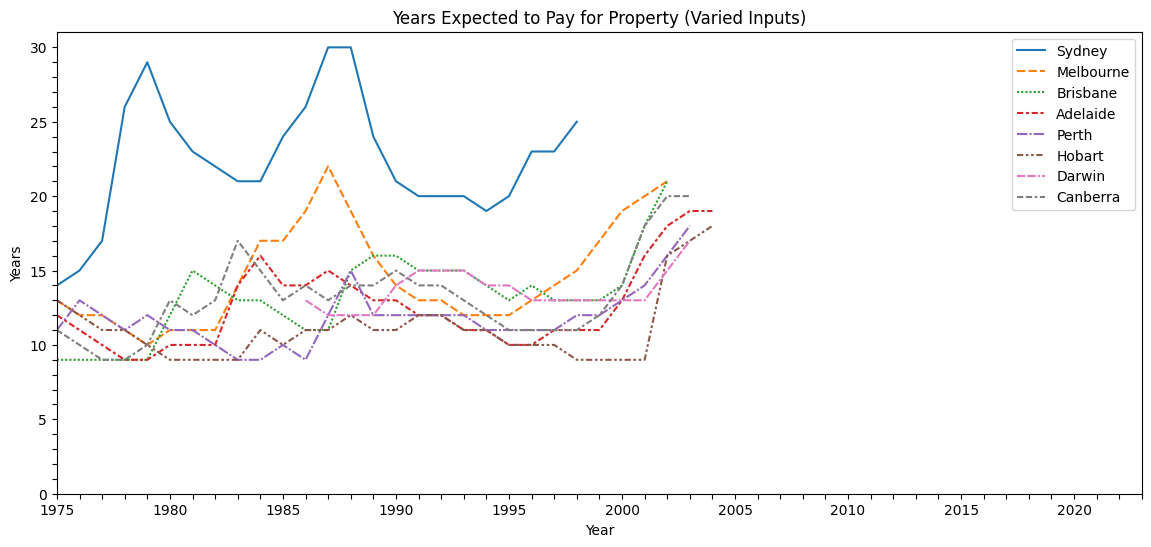

In [129]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyears)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Years Expected to Pay for Property (Varied Inputs)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=31)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(31), labels=['' if i % 5 != 0 else i for i in range(31)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

## With Forecasting

In [138]:
#let's calc constant years if rates and incomes stayed same
variedyearsdepositEst = prices*0 
variedyearsloanEst = prices*0

In [140]:
longGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[0])/MIH[state].iloc[0])**(1/49)-1
    longGrowthRates.append(avg)

In [141]:
fivYearGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[-5])/MIH[state].iloc[-5])**(1/5)-1
    fivYearGrowthRates.append(avg)

### Deposits

In [144]:
#iterate through the columns
col = 0
for i in variedyearsdepositEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while savings < goal and (row + year) < len(variedyearsdepositEst):
            savings = (savings + payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        payment = payments.iloc[-1, col]
        if savings < goal:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            count = 0
            while savings < goal:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment * multiplier

                try:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[count])
                except:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0


        if savings >= goal:
            variedyearsdepositEst.iloc[row,col] = year + months/12
        year = 0
        row += 1
    col += 1

### Mortgages

In [145]:
#iterate through the columns
col = 0
for i in variedyearsloanEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]
        
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while loan > 0 and (row + year) < len(variedyearsloan):
            loan = (loan - payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        payment = payments.iloc[-1, col]  
        if loan > 0:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            count = 0
            while loan > 0:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment * multiplier

                try:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[count])
                except:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0

        if loan <= 0:
            variedyearsloanEst.iloc[row,col] = year + months/12
        year = 0
        row += 1
    col += 1

### Total Years

In [149]:
variedyearsEst = variedyearsdeposit*np.nan

So we have to make it so that they sum from how long it took to pay for the loan. Eg. In 2002 it took 3 years to save for deposit, therefore we need to sum 2002 deposit years with 2005 mortgage years.

In [150]:
#variedyearsloan
#variedyearsdeposit

for j, col in enumerate(variedyearsdepositEst.columns):
    for i, col in enumerate(variedyearsdepositEst.index):
        try:
            depYears = round(variedyearsdepositEst.iloc[i, j])
            lonYears = variedyearsloanEst.iloc[i+depYears, j]
        except:
            depYears = np.nan
            lonYears = np.nan
        
        totYears = depYears + lonYears

        variedyearsEst.iloc[i, j] = totYears

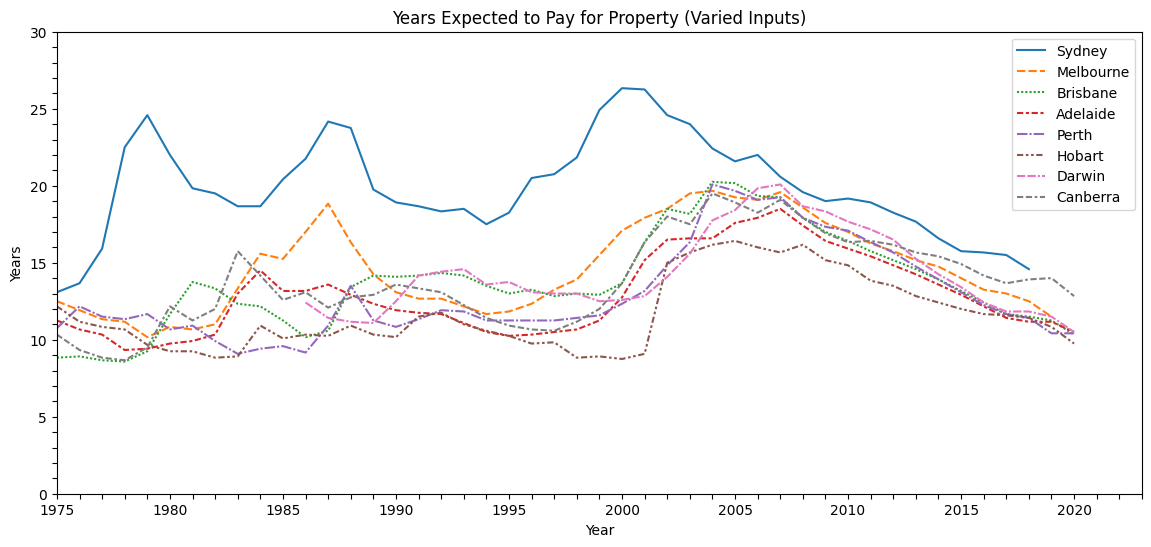

In [155]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsEst)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Years Expected to Pay for Property (Varied Inputs)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=31)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(31), labels=['' if i % 5 != 0 else i for i in range(31)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

# Fix exponenential income issues with additive growth method

In [138]:
#let's calc constant years if rates and incomes stayed same
variedyearsdepositEst = prices*0 
variedyearsloanEst = prices*0

In [140]:
longGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[0])/MIH[state].iloc[0])**(1/49)-1
    longGrowthRates.append(avg)

In [141]:
fivYearGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[-5])/MIH[state].iloc[-5])**(1/5)-1
    fivYearGrowthRates.append(avg)

## Deposits

In [157]:
payment

39186.56907470337

In [158]:
payment * multiplier - payment

877.367783510148

In [ ]:
Add = 877.367783510148

In [159]:
#iterate through the columns
col = 0
for i in variedyearsdepositEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while savings < goal and (row + year) < len(variedyearsdepositEst):
            savings = (savings + payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        payment = payments.iloc[-1, col]
        if savings < goal:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            add = payment*multiplier - payment
            
            count = 0
            while savings < goal:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment + add

                try:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[count])
                except:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0


        if savings >= goal:
            variedyearsdepositEst.iloc[row,col] = year + months/12
        year = 0
        row += 1
    col += 1

## Mortgages

In [476]:
#iterate through the columns
col = 0
for i in variedyearsloanEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]
        
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while loan > 0 and (row + year) < len(variedyearsloan):
            loan = (loan - payments.iloc[row+year, col])*(1+yearlyRatesEMR['mr'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        payment = payments.iloc[-1, col]  
        if loan > 0:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            add = payment*multiplier - payment
            
            count = 0
            while loan > 0:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment + add

                try:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[count])
                except:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0

        if loan <= 0:
            variedyearsloanEst.iloc[row,col] = year + months/12
        year = 0
        row += 1
    col += 1

KeyboardInterrupt: 

In [ ]:
variedyearsloanEst

## Total Years

In [161]:
variedyearsEst = variedyearsdeposit*np.nan

So we have to make it so that they sum from how long it took to pay for the loan. Eg. In 2002 it took 3 years to save for deposit, therefore we need to sum 2002 deposit years with 2005 mortgage years.

In [162]:
#variedyearsloan
#variedyearsdeposit

for j, col in enumerate(variedyearsdepositEst.columns):
    for i, col in enumerate(variedyearsdepositEst.index):
        try:
            depYears = round(variedyearsdepositEst.iloc[i, j])
            lonYears = variedyearsloanEst.iloc[i+depYears, j]
        except:
            depYears = np.nan
            lonYears = np.nan
        
        totYears = depYears + lonYears

        variedyearsEst.iloc[i, j] = totYears

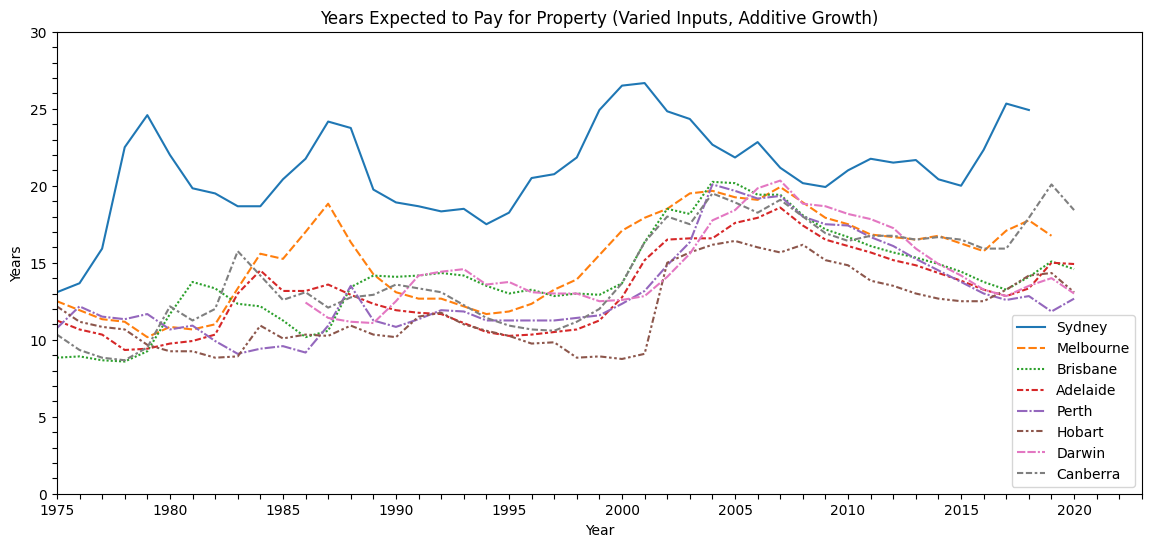

In [164]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsEst)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Years Expected to Pay for Property (Varied Inputs, Additive Growth)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=31)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(31), labels=['' if i % 5 != 0 else i for i in range(31)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

# Quarterly measures

## Data

In [410]:
# Prices
prices = pd.read_csv('data/HousePrices.csv') #thanks to ABS, Domain
prices = prices.set_index(prices['Date'])
prices = prices.drop('Year', axis = 1)

In [411]:
prices = prices*1000

In [428]:
# Interest rates
interestRates = interestRates.set_index(interestRates['Date'])
interestRates = interestRates.drop('Date', axis = 1)

In [429]:
interestRates.index = pd.to_datetime(interestRates.index)

In [436]:
interestRates

,3-month BAB/Deposit Yields,Cash rate target,Mortgage rates,mortgage fund,avg mortgage,emr,emr_deposit
Date,,,,,,,
1969-06-01,0.0590,NaN,NaN,NaN,NaN,NaN,0.004789
1969-07-01,0.0580,NaN,NaN,NaN,NaN,NaN,0.004709
1969-08-01,0.0610,NaN,NaN,NaN,0.094765,0.007573,0.004947
1969-09-01,0.0580,NaN,NaN,NaN,0.096214,0.007685,0.004709
1969-10-01,0.0560,NaN,NaN,NaN,0.098016,0.007823,0.004551
...,...,...,...,...,...,...,...
2023-08-01,0.0415,0.0410,0.0546,NaN,0.054600,0.004440,0.003394
2023-09-01,0.0413,0.0410,0.0551,NaN,0.055100,0.004480,0.003378
2023-10-01,0.0421,0.0410,0.0556,NaN,0.055600,0.004519,0.003442


In [438]:
dep = []
mor = []
sum = [0, 0]
for i, index_value in enumerate(interestRates.index):
    if index_value >= pd.Timestamp('2002-01-01 00:00:00'):
        sum[0] += interestRates.loc[index_value, 'emr_deposit']
        sum[1] += interestRates.loc[index_value, 'emr']
        if (i + 1) % 3 == 0:
            dep.append(sum[0] / 3)
            mor.append(sum[1] / 3)
        sum[0] = 0
        sum[1] = 0

In [440]:
quarterlyRatesEMR = pd.DataFrame({"deposit": dep, "mortgage": mor})

<Axes: >

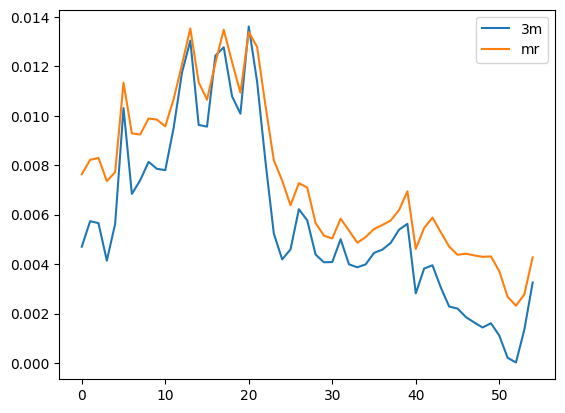

In [441]:
yearlyRatesEMR[['3m','mr']].plot()

<Axes: >

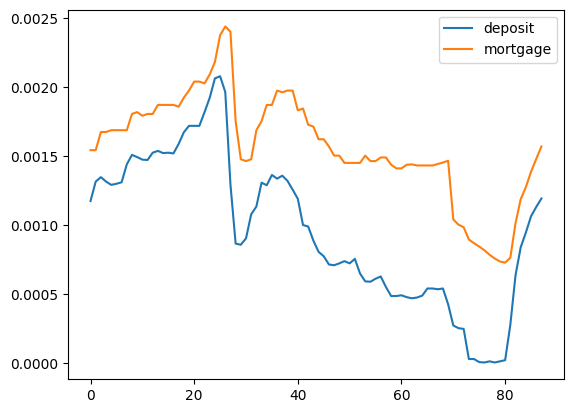

In [442]:
quarterlyRatesEMR.plot()

## Deposits

In [351]:
variedqtrsdepositEst = prices*np.nan

In [390]:
deposit = prices*0.2

In [356]:
payments = MIH*0.27

In [357]:
payments = payments[len(payments)-22:]

In [360]:
# Duplicate each row in the DataFrame
payments = payments.reindex(payments.index.repeat(4)).reset_index(drop=True)

# Insert three additional rows after each duplicated row and fill them with the values from the duplicated row
for i in range(len(payments)):
    if i % 4 != 0:
        payments.loc[i] = payments.loc[i-1]

In [405]:
payments = payments[0:87]

In [20]:
#let's calc constant years if rates and incomes stayed same
constantyearsdeposit = prices*0 
constantyearsloan = prices*0 #create a database for years

Variable of interest is payments, initially it was set at 0.27 the MIH. There are no issues with deposits...

## Constant Inputs

### Deposit

In [413]:
constantyearsdeposit = prices * np.nan

In [443]:
cityindex = 0
row = 0
for city in constantyearsdeposit.columns:
    for i in constantyearsdeposit.index:
        try:
            #print(city, row)
            constantyearsdeposit.iloc[row, cityindex] = value = (math.log(deposit.iloc[row, cityindex]/payments.iloc[row, cityindex] * quarterlyRatesEMR['deposit'].iloc[row]+1) / math.log(1+quarterlyRatesEMR['deposit'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsdeposit.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

<Axes: xlabel='Date'>

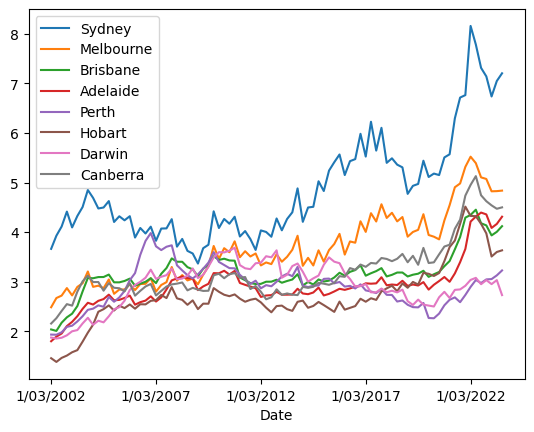

In [445]:
constantyearsdeposit.plot()

### Mortgage

In [451]:
loans = prices

In [450]:
constantyearsloan = prices * np.nan

In [452]:
cityindex = 0
row = 0
for city in constantyearsloan.columns:
    for i in constantyearsloan.index:
        try:
            #print(city, row)
            constantyearsloan.iloc[row, cityindex] = value = (math.log(1/-((loans.iloc[row, cityindex]*quarterlyRatesEMR['mortgage'].iloc[row]/payments.iloc[row, cityindex])-1)) / math.log(1+quarterlyRatesEMR['mortgage'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            #print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsloan.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

In [453]:
constyears = constantyearsdeposit + constantyearsloan

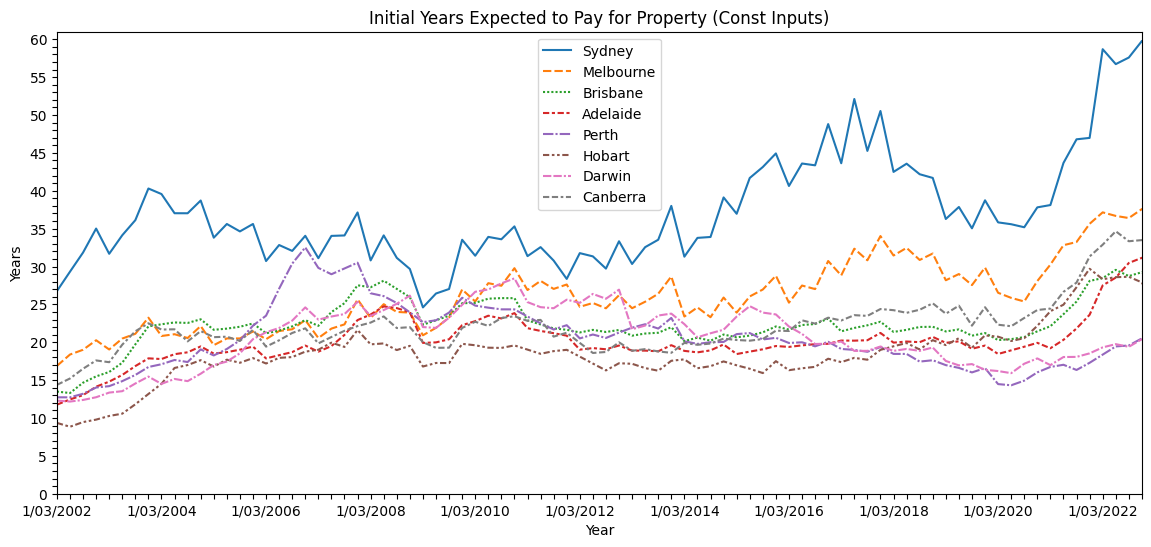

In [545]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=constyears)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Initial Years Expected to Pay for Property (Const Inputs)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 8 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(61), labels=['' if i % 5 != 0 else i for i in range(61)])
plt.ylim(0, 61)  # Set y-axis limits to 0 and 61

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [462]:
# Create an ExcelWriter object
excel_writer = pd.ExcelWriter('constInputsQtrly.xlsx', engine='xlsxwriter')

# Write each DataFrame to a separate worksheet
constantyearsdeposit.to_excel(excel_writer, sheet_name='deposit years')
constantyearsloan.to_excel(excel_writer, sheet_name='loan years')
constyears.to_excel(excel_writer, sheet_name='total years')

# Add more DataFrames as necessary

# Close the Pandas Excel writer and output the Excel file
excel_writer.close()

## Varied inputs

### Deposits

In [463]:
variedyearsdeposit = prices*np.nan

In [471]:
#iterate through the columns
col = 0
for i in variedyearsdepositEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        qtr = 0
        while savings < goal and (row + qtr) < len(variedyearsdepositEst):
            savings = (savings + payments.iloc[row+qtr, col])*(1+quarterlyRatesEMR['deposit'].iloc[row+qtr]) 
            #print("bal: ", savings)
            months += 1
            if (months == 3):
                qtr += 1
                months = 0
                
        payment = payments.iloc[-1, col]
        if savings < goal:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            add = (payment*multiplier - payment)/4
            
            count = 0
            while savings < goal:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment + add

                try:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[int(count)])
                except:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[-1])
                months += 1
                count += 0.25
                if (months == 3):
                    qtr += 1
                    months = 0


        if savings >= goal:
            variedyearsdepositEst.iloc[row,col] = qtr/4 + months/12
        qtr = 0
        row += 1
    col += 1

### Mortgage

In [485]:
loans = prices*0.8

In [516]:
variedyearsloanEst = prices * np.nan

In [530]:
#iterate through the columns
col = 0
for i in variedyearsloanEst.columns:
    #iterate through the rows
    row = 0
    #print("city:", variedyearsloanEst.columns[col])
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]

        #print("date:", variedyearsloanEst.index[row])
        #print("loan starting amount:", loan)
        
        months = 0
        qtr = 0
        while loan > 0 and (row + qtr) < len(variedyearsloanEst):
            loan = (loan - payments.iloc[row+qtr, col])*(1+quarterlyRatesEMR['mortgage'].iloc[row+qtr]) 
            #print("bal: ", savings)
            months += 1
            if (months == 3):
                qtr += 1
                months = 0
                
        payment = payments.iloc[-1, col]  
        if loan > 0:
            #print("Have to pay off past 2023")
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            add = (payment*multiplier - payment)
            
            count = 0
            while loan > 0:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment + add

                try:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[int(count)])
                    #print(int(count))
                except:
                    print("fail")
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[-1])
                months += 1
                count+= 0.25
                if (months == 3):
                    qtr += 1
                    months = 0

        if loan <= 0:
            variedyearsloanEst.iloc[row,col] = qtr/4 + months/12
        qtr = 0
        row += 1
    col += 1

### Total Years

In [536]:
variedyearsEst = variedyearsdepositEst*np.nan

In [537]:
#variedyearsloan
#variedyearsdeposit

for j, col in enumerate(variedyearsdepositEst.columns):
    for i, col in enumerate(variedyearsdepositEst.index):
        try:
            depYears = round(variedyearsdepositEst.iloc[i, j])
            lonYears = variedyearsloanEst.iloc[i+depYears, j]
        except:
            depYears = np.nan
            lonYears = np.nan
        
        totYears = depYears + lonYears

        variedyearsEst.iloc[i, j] = totYears

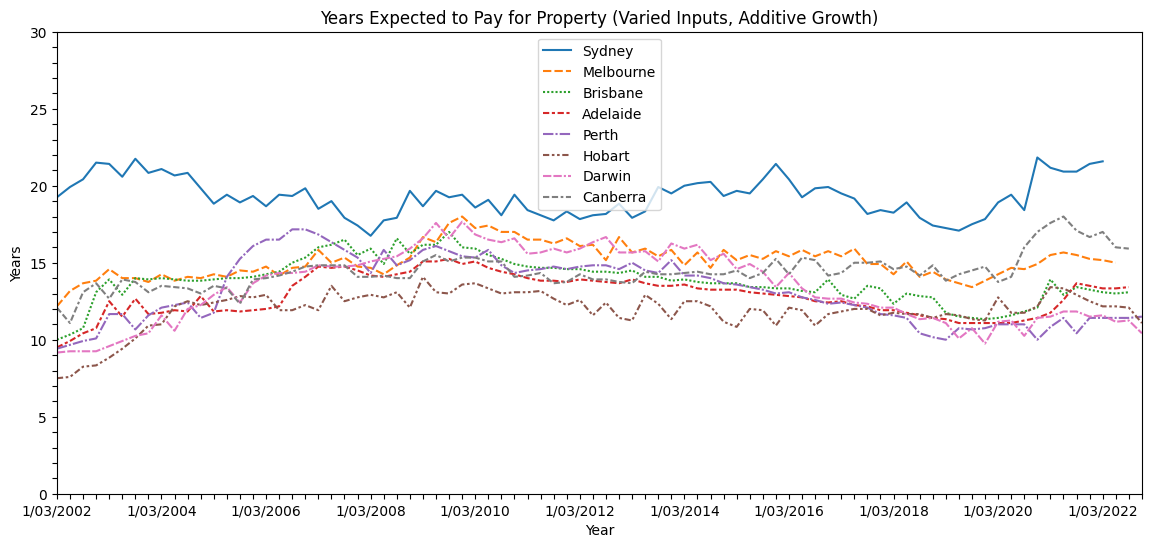

In [541]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsEst)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Years Expected to Pay for Property (Varied Inputs, Additive Growth)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 8 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=31)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(31), labels=['' if i % 5 != 0 else i for i in range(31)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [542]:
# Create an ExcelWriter object
excel_writer = pd.ExcelWriter('varyInputsQtrly.xlsx', engine='xlsxwriter')

# Write each DataFrame to a separate worksheet
variedyearsdepositEst.to_excel(excel_writer, sheet_name='deposit years')
variedyearsloanEst.to_excel(excel_writer, sheet_name='loan years')
variedyearsEst.to_excel(excel_writer, sheet_name='total years')

# Add more DataFrames as necessary

# Close the Pandas Excel writer and output the Excel file
excel_writer.close()